<a href="https://colab.research.google.com/github/rimiiii/basic/blob/main/torch_RNN_with_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install torchsummaryX

In [17]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=9627d1444708fe95724b12a4464e0568f007d698c070a192c75933150b2324cd
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


# 모듈 불러오기

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummaryX import summary
from torchviz import make_dot

from matplotlib import pyplot as plt
%matplotlib inline

# 분석 환경 설정

In [5]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print('Current cuda device is', device)

Current cuda device is cuda


# Hyperparameter 지정

In [6]:
batch_size = 50
epoch_num = 20
learning_rate = 0.0001
hidden_size = 128
num_layers = 2

# 데이터 불러오기

In [7]:
train = datasets.MNIST(root='./data', train=True, download=True,
                       transform=transforms.ToTensor())
test = datasets.MNIST(root='./data', train=False, download=True,
                      transform=transforms.ToTensor())

print('number of training data', len(train))
print('number of test data', len(test))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

number of training data 60000
number of test data 10000


# MNIST 데이터 확인하기

image shape: torch.Size([1, 28, 28]), label: 5


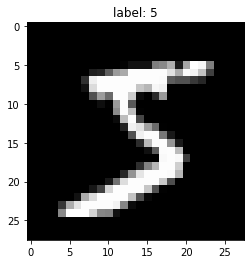

In [8]:
image, label = train[0]

print(f'image shape: {image.shape}, label: {label}')
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title('label: %s' % label)
plt.show()

# 미니 배치 구성하기

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test,
                                          batch_size=batch_size,
                                          shuffle=True)

first_batch = train_loader.__iter__().__next__()
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[1])), first_batch[1].shape))

name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50])


# RNN 구조 설계하기

In [10]:
class RNN(nn.Module):
  def __init__(self):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(28, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 10)

  def forward(self, x):
    # hidden, cell states 초기화
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) #x.size(0): batch_size
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    # forward propagate LSTM
    x, _ = self.lstm(x, (h0, c0)) #out shape: (batch_size, seq_length, hidden_size)

    # 마지막 step만 꺼내기
    x = self.fc(x[:, -1, :])
    output = F.log_softmax(x, dim=1)
    return output

# Optimizer 및 손실 함수 정의

In [11]:
model = RNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# 설계한 RNN 모형 확인하기

In [12]:
print(model)

RNN(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


In [16]:
summary(model, torch.zeros((1,28,28)).to(device))

       Kernel Shape  Output Shape  Params  Mult-Adds
Layer                                               
0_lstm            -  [1, 28, 128]  212992     210944
1_fc      [128, 10]       [1, 10]    1290       1280
----------------------------------------------------
                      Totals
Total params          214282
Trainable params      214282
Non-trainable params       0
Mult-Adds             212224


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_lstm,-,"[1, 28, 128]",212992,210944
1_fc,"[128, 10]","[1, 10]",1290,1280


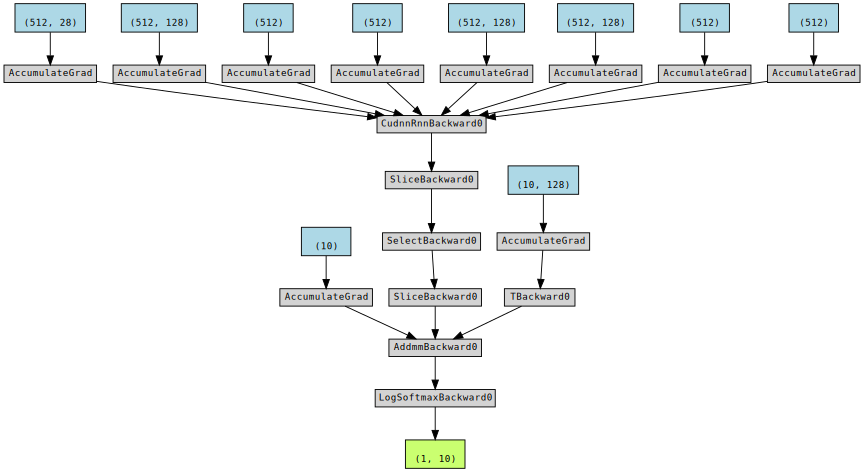

In [19]:
make_dot(model(torch.zeros((1,28,28)).to(device)))

# 모델 학습

In [ ]:
model.train()
i = 0
for epoch in range(epoch_num):
  for data, target in train_loader:
    data = data.reshape(-1, 28, 28).to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
      print('Train step: {}\tLoss: {:.3f}'.format(i, loss.item()))
    i += 1

Train step: 0	Loss: 2.304
Train step: 1000	Loss: 0.289
Train step: 2000	Loss: 0.174
Train step: 3000	Loss: 0.216
Train step: 4000	Loss: 0.071
Train step: 5000	Loss: 0.066
Train step: 6000	Loss: 0.027
Train step: 7000	Loss: 0.122
Train step: 8000	Loss: 0.047
Train step: 9000	Loss: 0.162
Train step: 10000	Loss: 0.070
Train step: 11000	Loss: 0.177
Train step: 12000	Loss: 0.014
Train step: 13000	Loss: 0.100
Train step: 14000	Loss: 0.072
Train step: 15000	Loss: 0.060
Train step: 16000	Loss: 0.058
Train step: 17000	Loss: 0.064
Train step: 18000	Loss: 0.079
Train step: 19000	Loss: 0.024
Train step: 20000	Loss: 0.061
Train step: 21000	Loss: 0.051
Train step: 22000	Loss: 0.006
Train step: 23000	Loss: 0.007


# 모델 평가

In [ ]:
model.eval()
correct = 0
for data, target in test_loader:
  data = data.to(device)
  target = target.to(device)
  output = output.to(device)
  prediction = output.data.max(1)[1]
  correct += prediction.eq(target.data).sum()

print('Test set: Accuracy: {:.2f}%'.format(100 * correct / len(test_loader.dataset)))

Test set: Accuracy: 10.01%
